In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
df = pd.read_csv("DataGeneration/df_features.csv")
y = df['etiquette']
df.drop(columns=['Unnamed: 0','etiquette'],inplace=True)
df
scaler = joblib.load("Models/OtherModels/scaler.pkl")
X_train, X_test, y_train, y_test = train_test_split(df,y,test_size=0.2,random_state=42)
# rf_model = joblib.load("random_forest_model.pkl")
ggb_model = joblib.load("Models/OtherModels/GradientGboost_model.pkl")
lr_model = joblib.load("Models/OtherModels/Logestic_Regression_model.pkl")
svm_model = joblib.load("Models/OtherModels/SVM_model.pkl")
xgb_model = joblib.load("Models/OtherModels/xgb_model.pkl")
dt_model = joblib.load("Models/OtherModels/Decision_tree.pkl")
lgbm_model = joblib.load("Models/OtherModels/LightGBM_model.pkl")
rf_model = joblib.load("Models/RandomForestModel/notebooks/random_forest_model.pkl")
knn_model = joblib.load("Models/KNNModel/notebooks/knn.pkl")
nb_gaussian_model = joblib.load("Models/GaussianNaiveBayesModel/notebooks/gaussian_nb.pkl")
X_test = scaler.transform(X_test)





In [15]:
models = {
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "Gradient Boosting": ggb_model,
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model,
    "KNN": knn_model,
    "Naive Bayes": nb_gaussian_model
}


Logistic Regression
Decision Tree
Random Forest
SVM
Gradient Boosting
XGBoost
LightGBM
KNN
Naive Bayes


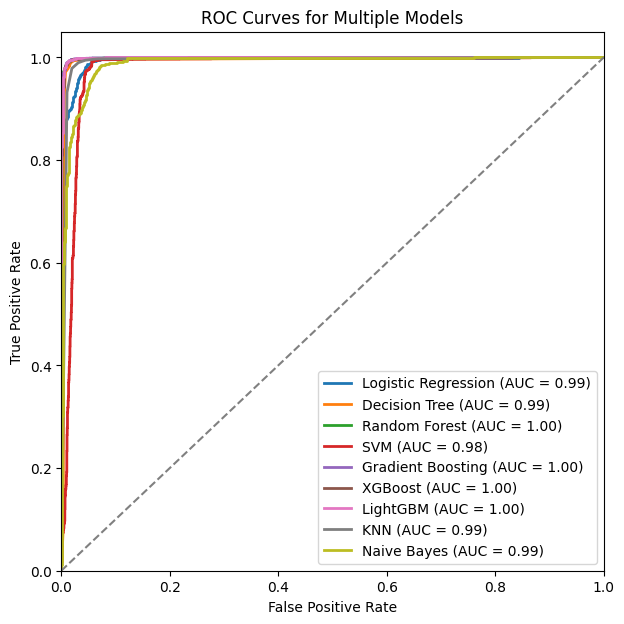

In [16]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(7, 7))
    
    for name, model in models.items():
        print(name)
        # If model has predict_proba
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        # Else (e.g., some SVMs) use decision_function
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            raise ValueError(f"Model {name} has no probability or decision scores.")

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")
    
    # Random chance line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Models')
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curves(models, X_test, y_test)


In [17]:

def plot_precision_recall_curve(models,y_true):
    """
    Affiche la courbe précision-rappel à partir des vraies étiquettes et des scores du modèle.

    Paramètres :
        y_true : array-like, les vraies étiquettes (0 ou 1)
        y_scores : array-like, les scores de prédiction (proba pour classe 1)
        model_name : str, nom du modèle pour le titre
    """
    plt.figure(figsize=(6, 4))
    for name in models.keys():
        y_scores = models[name].predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_true, y_scores)

        plt.plot(recall, precision, lw=2,label=name)
    plt.xlabel("Rappel")
    plt.ylabel("Précision")
    plt.title(f"Courbe Précision-Rappel ")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

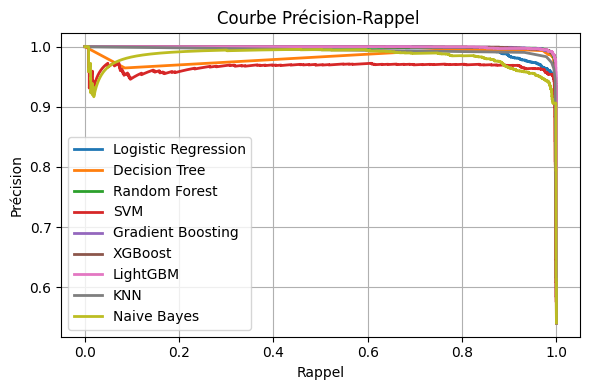

In [18]:
plot_precision_recall_curve(models,y_test)

In [19]:
def plot_scores_vs_threshold(models, y_true):
    """
    Affiche précision, rappel et F1-score en fonction du seuil pour plusieurs modèles sur le même graphique.

    Paramètres :
        models : dict {nom_modele: modele}
        y_true : array-like, vraies étiquettes (0 ou 1)
    """
    plt.figure(figsize=(10, 6))

    thresholds = np.linspace(0.0, 1.0, 100)

    for name in models.keys():
        # Récupération des scores
        if hasattr(models[name], "predict_proba"):
            y_scores = models[name].predict_proba(X_test)[:, 1]
        else:  # Exemple pour SVM sans probability=True
            y_scores = models[name].decision_function(X_test)

        precision_list = []
        recall_list = []
        f1_list = []

        for t in thresholds:
            y_pred = (y_scores >= t).astype(int)
            precision_list.append(precision_score(y_true, y_pred, zero_division=0))
            recall_list.append(recall_score(y_true, y_pred, zero_division=0))
            f1_list.append(f1_score(y_true, y_pred, zero_division=0))

        # Tracer les courbes
        plt.plot(thresholds, precision_list, label=f'Précision - {name}', linestyle='-')
        plt.plot(thresholds, recall_list, label=f'Rappel - {name}', linestyle='--')
        plt.plot(thresholds, f1_list, label=f'F1 - {name}', linestyle=':')

        plt.xlabel("Seuil")
        plt.ylabel("Score")
        plt.title("Évolution des scores selon le seuil de classification")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Modèle": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Précision": precision_score(y_test, y_pred),
        "Rappel": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
results_df


,Modèle,Accuracy,Précision,Rappel,F1-Score
6,LightGBM,0.989525,0.988625,0.992044,0.990331
4,Gradient Boosting,0.989151,0.987944,0.992044,0.989990
5,XGBoost,0.988777,0.988946,0.990315,0.989630
2,Random Forest,0.988590,0.988268,0.990661,0.989463
1,Decision Tree,0.986719,0.985203,0.990315,0.987752
7,KNN,0.979985,0.973792,0.989623,0.981644
0,Logistic Regression,0.968762,0.951592,0.992736,0.971728
3,SVM,0.962028,0.962173,0.967831,0.964994
8,Naive Bayes,0.955294,0.946765,0.971982,0.959208


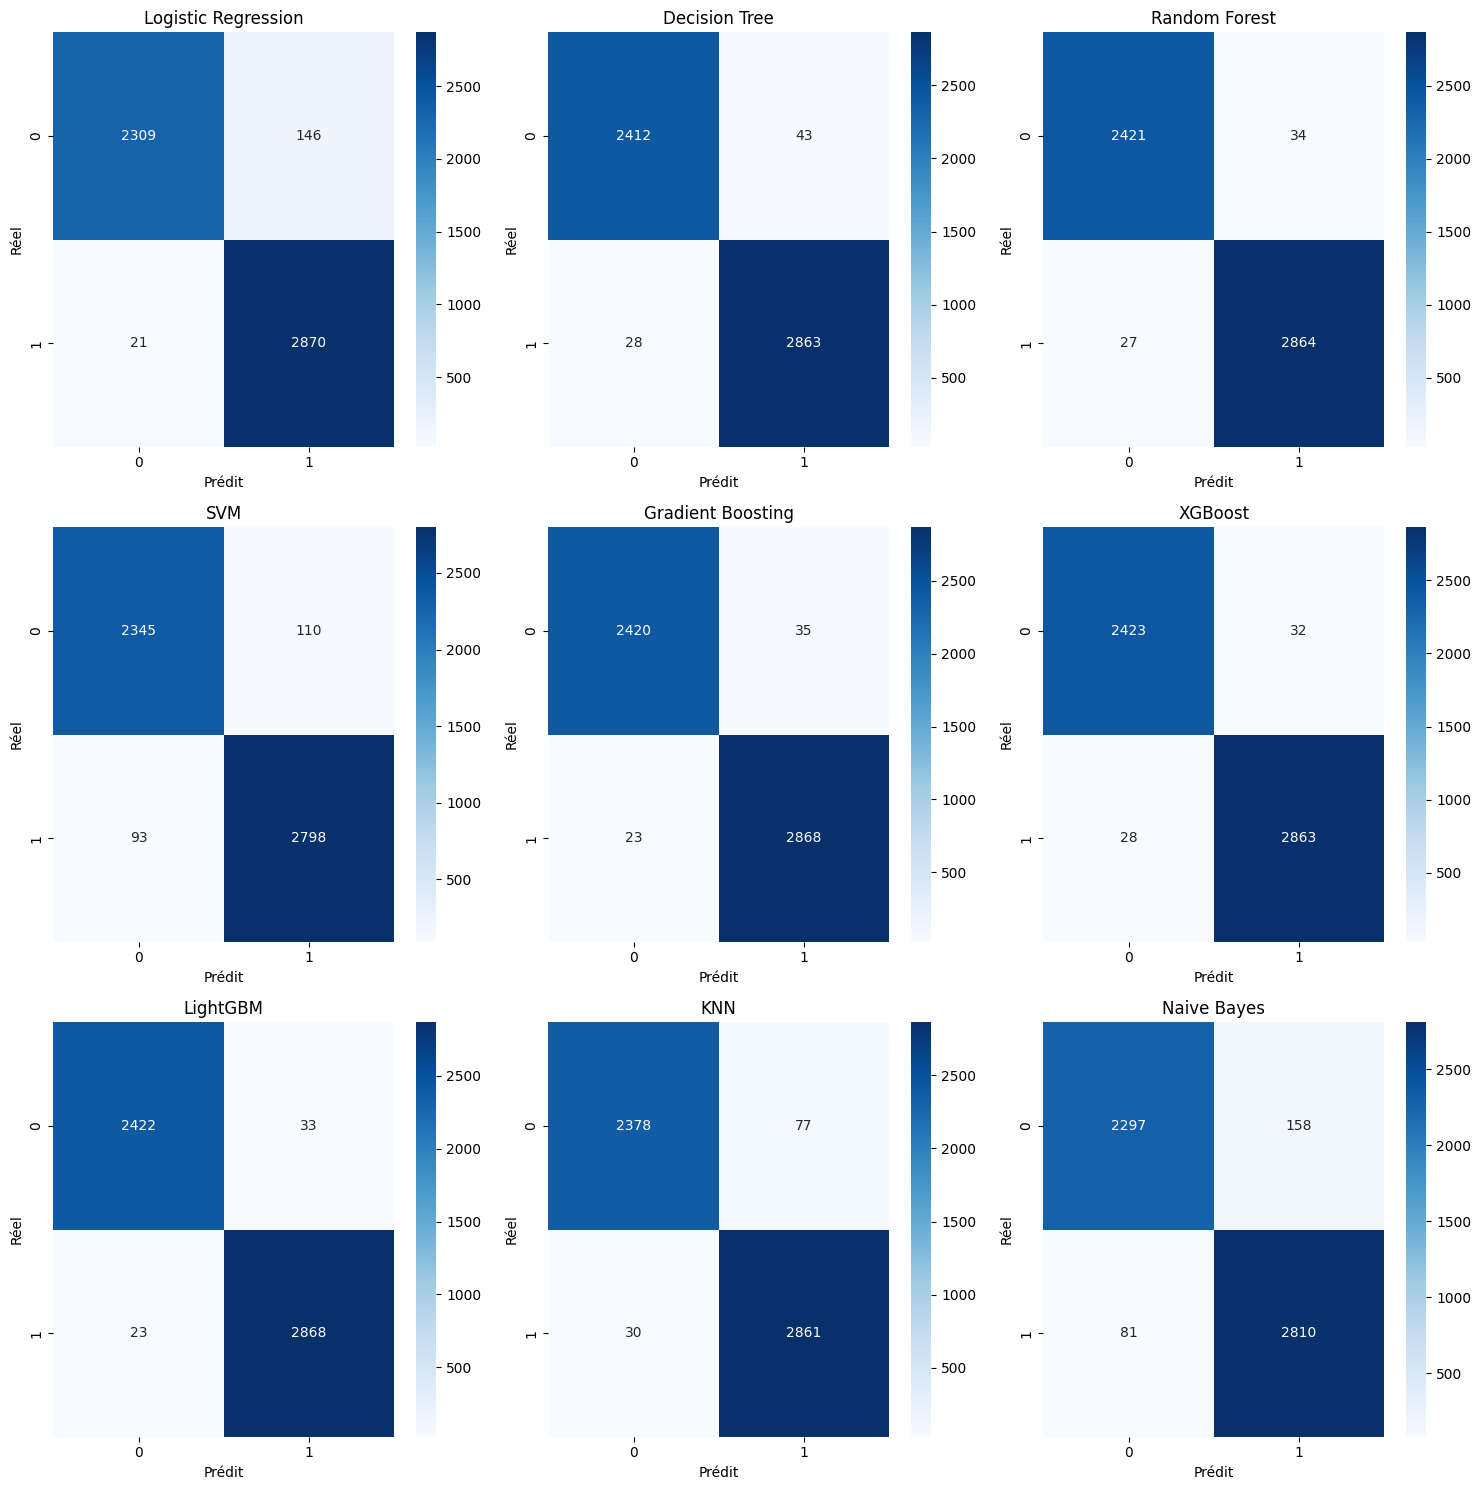

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Prédit")
    axes[i].set_ylabel("Réel")

plt.tight_layout()
plt.show()
